In [2]:
#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

___
Enter Team Member Names here (double click to edit):

- Jeremy Otsap - jotsap@mail.smu.edu
- Shawn Jung - shawnj@mail.smu.edu
- Lance Dacy - ldacy@mail.smu.edu
- Amber Burnett - aburnett@mail.smu.edu
________

# In Class Assignment Four
In the following assignment you will be asked to fill in python code and derivations for a number of different problems. Please read all instructions carefully and turn in the rendered notebook (or HTML of the rendered notebook) before the end of class. Be sure to save the notebook before uploading!

<a id="top"></a>
## Contents
* <a href="#cluster">Create Clustering Data</a>
* <a href="#kmeans">K-means Clustering</a>
* <a href="#mini">MiniBatch K-Means</a>
* <a href="#dbscan">Using DBSCAN</a>

________________________________________________________________________________________________________
<a id="cluster"></a>
<a href="#top">Back to Top</a>
## Clustering
Please run the following code to create synthetic datasets on a two dimensional plane. Three sets of data are created and saved into variables `X1`, `X2`, and `X3`. Each dataset is plotted afterward. We will be using `scikit-learn` to perform clustering on each dataset. You do not need to understand the specifics of the code in the next block, just know that three datasets are created with two attributes in each dataset (*i.e.*, two columns), and they are saved into variables `X1`, `X2`, and `X3`.

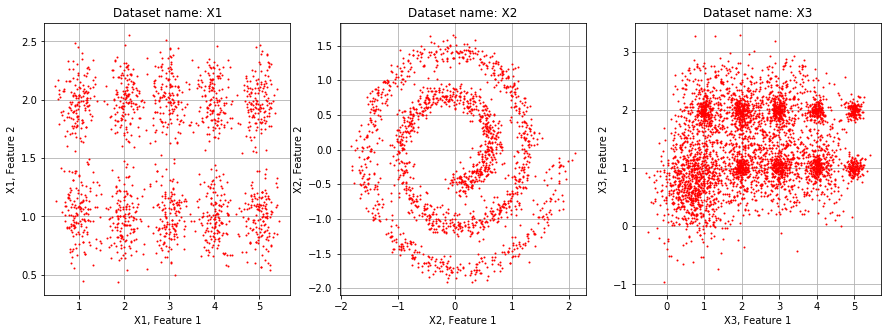

In [2]:
# getting things started
from __future__ import print_function
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np


# generate some sample data
n_samples = 1700
np.random.seed(0)

#======= Sample data ONE
cluster_centers = [[1.0,1], [1,2], [2,1], [2,2], [3,1], [3,2], [4,1], [4,2], [5,1], [5,2]]
X1 = np.array(cluster_centers) # cluster prototypes
X1 = np.repeat(X1, 150, axis=0)
X1 += .2 * np.random.randn(X1.shape[0],2) # add some randomness

#====== Sample data TWO
# Generate some harder sample data
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t) / 10.0
y = t * np.sin(t) / 10.0

X2 = np.concatenate((x, y))
X2 += .1 * np.random.randn(2, n_samples) # add some randomness
X2 = X2.T # and transpose it

#====== Sample data THREE
cluster_centers[0] = [0.75,0.75]
cluster_centers.insert(0,[0.75,0.75])
X3 = np.array(cluster_centers) # cluster prototypes
X3 = np.repeat(X3, 150, axis=0)
X3 += .1 * np.random.randn(X3.shape[0],2) # add some randomness
X3[0:300] += .3 * np.random.randn(300,2) # add spread to first class

n_samples = int(len(X3)/4*3)
Xtmp1 = X3[0:n_samples] + .4 * np.random.randn(n_samples,2) # create some spread in the points
Xtmp2 = X3[0:n_samples] + .4 * np.random.randn(n_samples,2) # create some spread in the points
X3 = np.concatenate((X3,Xtmp1,Xtmp2)) # and add them back in for differing density

# now plot each dataset
plt.figure(figsize=(15,5))
for i,X in enumerate([X1,X2,X3]):
    plt.subplot(1,3,i+1)
    plt.plot(X[:, 0], X[:, 1], 'r.', markersize=2) #plot the data
    plt.title('Dataset name: X{0}'.format(i+1))
    plt.xlabel('X{0}, Feature 1'.format(i+1))
    plt.ylabel('X{0}, Feature 2'.format(i+1))
    plt.grid()

plt.show()

**Questions**: For each dataset, is it: 
- best described as center-based, contiguous, or density based (or a mix of more than one)? 
- best described as partitional or hierarchical?  

**Question**: Given the plots above for each dataset, what type of clustering algorithm would you consider using for each and why? That is, give your opinion on whether k-means, hierarchical agglomerative, and/or DBSCAN are appropriate for each dataset.

___
Enter your answer here:

Q1: For X1, it is center based and partitional. There does not appear to be any density problems--the clusters all appear to have concentrations in the center, with no real noise points. As such, k-means would work well. Hierarchical with Ward's method or DBSCAN would also do well because it is well separated.

Q2: This appears to be contiguous and partitional, with consistent density across the swirl. As such, DBSCAN would probably be the best bet. Agglomerative might work, but would need connectivity constraints to prevent globular clustering of the swirl.

Q3: This is center based, but also has density differences where clusters are located. It appears to be partitional, though an argument for hierarchical can be made because there is one large cluster (that makes up a good deal of the noise in the data) and a smaller more dense cluster inside it on the bottom left. DBSCAN may be the only possible algorithm to use here because of the noise points. Gaussian mixtures models would work well here, although we have not talked about that yet. 

___

___
<a id="kmeans"></a>
<a href="#top">Back to Top</a>
## Kmeans Clustering in Scikit
Now lets look at calculations in K-Means clustering with `scikit-learn` and see if we can calculate the difference between two different clusterings. Lets start by using k-means clustering on the first dataset. The code is given for you below as well as code for plotting the centroids, as shown. Take a look to see how k-means is run.

You can also see the documentation for k-means here:
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

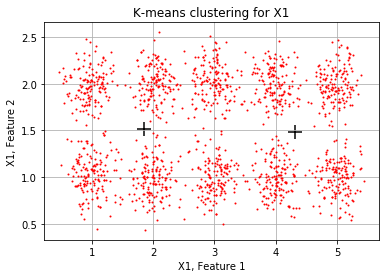

In [35]:
from sklearn.cluster import KMeans

# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(init='random', # initialization
        n_clusters=2,  # number of clusters
        n_init=1,       # number of different times to run k-means
        n_jobs=-1)

kmeans.fit(X1)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

**Questions**: 
- Is the above a good clustering of the data? Why or why not? 
- Run the block of code a few times. Did the results ever improve? Is the clustering consistent? 
- How might we make the clustering more consistent in finding the optimal clustering (i.e., the clustering with the smallest SSE)?

___
Enter your answer here:

The above clustering is clearly sub-optimal. Subsequent runs are also not working too well. If run enough, the optimal clustering is found, but not consistently. To be more consistent, we could change the number of times we run k-means or use a better initialization.

In the code below, it appears that k-means++ is a viable initialization method and does not require multiple runs to consistently find the optimal SSE solution.  

___
## K-means consistency
**Exercise**: Now let's try to make the kmeans clustering more consistent. Change the `n_init` and `init` parameters of kmeans such that (almost) every time you run the block of code, the optimal clustering is found. Make sure that the solution you find is as *efficient as possible*.

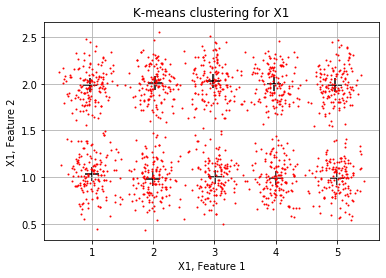

In [30]:
from sklearn.cluster import KMeans

#--------Change parameters below this line---------------------------
# CHANGE THE PARAMETERS HERE TO GET A CONSISTENTLY OPTIMAL CLUSTERING
# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(
    init='k-means++',    # initialization
    n_clusters=10,    # number of clusters
    n_init=1,         # number of different times to run k-means
    n_jobs=-1)
#--------Change parameters above this line---------------------------

kmeans.fit(X1)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

___
# Start of Live Sesion Assignment

<a id="mini"></a>
<a href="#top">Back to Top</a>
## Mini-batching for better performance
Traditional Kmeans uses a "Batch" approach where each point is looked at for every iteration. By incrementally updating the centroids in the space, we can get a more efficient way of finding the centroids without visiting every point in the dataset at each iteration. We talked about this in the video lecture and it was called "Mini-Batch Kmeans." The following code will run both kmeans and mini-batch kmeans using `scikit-learn`'s implementations. The mini-batch size is set currently to ten instances. Each algorithm is timed for each run and the times are shown after the block of code (I am using the `%time` magics for ipython). Answer the questions that follow this block of code.


Time for BatchKMeans:
CPU times: user 46.3 ms, sys: 3.25 ms, total: 49.5 ms
Wall time: 47.7 ms
Time for MiniBatchKMeans:
CPU times: user 61.5 ms, sys: 441 µs, total: 61.9 ms
Wall time: 61.7 ms


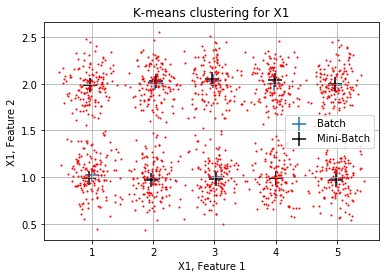

In [13]:
from sklearn.cluster import MiniBatchKMeans

kmeans_mini = MiniBatchKMeans(n_clusters=10, batch_size=10)
kmeans = KMeans(n_clusters=10)

print('Time for BatchKMeans:')
%time kmeans.fit(X1)
print('Time for MiniBatchKMeans:')
%time kmeans_mini.fit(X1)


# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')  # plot the centroids

centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')  # plot the centroids
plt.legend()
plt.title('K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

**Questions**: 
- Is mini-batch faster than kmeans for this example? Does this make sense to you? Why or why not?
- Are the results comparable to one another? 
 - To compare the results mathematically, what objective function would you use?
 - Does `scikit-learn`'s implementation have a property in the fitted object for getting the value of this objective function?
 - If so, compare the objective function value for the `kmeans` object and the `kmeans_mini` object. Which is better?

___
Enter your answer here:

*Double Click to Edit*



Enter any calculations needed below:

In [14]:
# Use this space for any calculations you may want to perform for the objective function

print('Batch objective function value:', kmeans.inertia_)
print('Mini-Batch objective function value:', kmeans_mini.inertia_)

Batch objective function value: 109.87509274288414
Mini-Batch objective function value: 111.34646033170303


___
<a id="dbscan"></a>
<a href="#top">Back to Top</a>
## DBSCAN 
Now lets use the remaining datasets to investigate the use of DBSCAN clustering. As a reminder, this is what the two datasets look like:

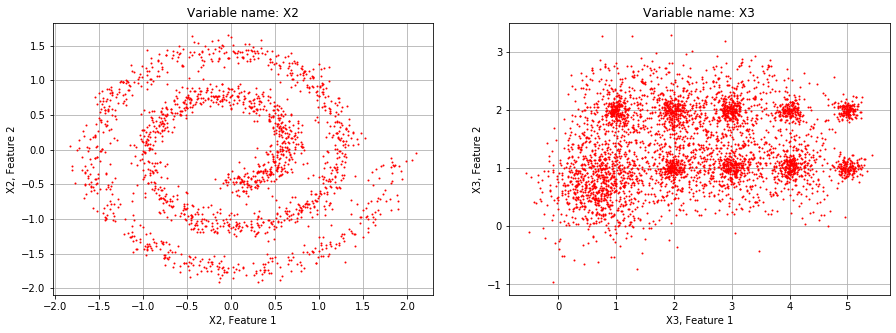

In [15]:
from sklearn.cluster import DBSCAN

# now plot each dataset
plt.figure(figsize=(15,5))
for i,X in enumerate([X2,X3]):
    plt.subplot(1,2,i+1)
    plt.plot(X[:, 0], X[:, 1], 'r.', markersize=2) #plot the data
    plt.title('Variable name: X{0}'.format(i+2))
    plt.xlabel('X{0}, Feature 1'.format(i+2))
    plt.ylabel('X{0}, Feature 2'.format(i+2))
    plt.grid()

plt.show()

___
Recall that with DBSCAN, we need to set the values for eps and for MinPts to create core points, border points, and noise points. 

**Question**: Can you come up with a reasonable value for *eps* and *MinPts* from the above graphs? What are your guesses and why did you choose them?
  

___
Enter your answer here:

*Double Click to Edit*



___

Now, let's investigate the value of MinPts and eps for the given datasets by graphing out the distances to the $N^{th}$ nearest neighbors (as we did at the end of the lecture video). This example sets N=4, but you can change it to be whatever value you think is reasonable from above. You can also try changing the value to find a better graph.

The code below will calculate and graph the distances to the $N^{th}$ nearest neighbors for each dataset (the variable names are `X2_N` and `X3_N`). **Exercise**: Investigate the graphs at the end and choose a value of MinPts and Eps for each dataset. **Question**: What is the value of Eps and MinPts and why do you think it will work given these graphs?

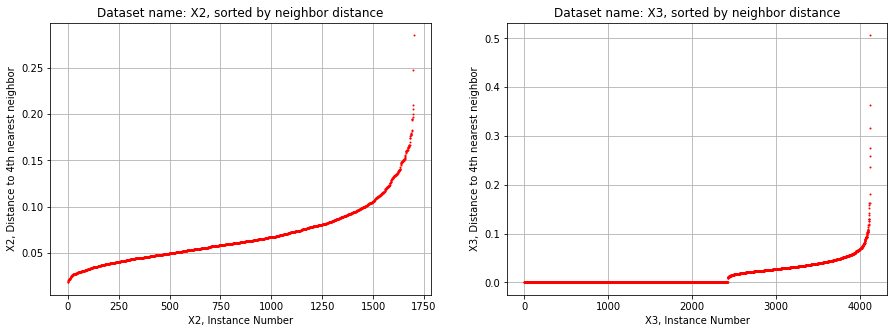

In [37]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X2_N = 4
X3_N = 4
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X2_knn_graph = kneighbors_graph(X2, X2_N, mode='distance') # calculate distance to four nearest neighbors 
X3_knn_graph = kneighbors_graph(X3, X3_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)

N3 = X3_knn_graph.shape[0]
X3_4nn_distances = np.zeros((N3,1))
for i in range(N2):
    X3_4nn_distances[i] = X3_knn_graph[i,:].max()

X3_4nn_distances = np.sort(X3_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(N3), X3_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X3, sorted by neighbor distance')
plt.xlabel('X3, Instance Number')
plt.ylabel('X3, Distance to {0}th nearest neighbor'.format(X3_N))
plt.grid()

plt.show()

___
Enter your answer here:

*Double Click to Edit*
 

___

___
## DBSCAN testing eps and minpts
Now test your values of eps from the above question for each dataset. The code below will train and plot clusters with the given parameters. **Analysis**: Enter your chosen MinPts and Eps parameters for each dataset and analyze the output. 
- Do the parameters you chose for these datasets end up with valid clusterings? Why or why not? 
- What range of parameters would give valid clusterings for each dataset? 

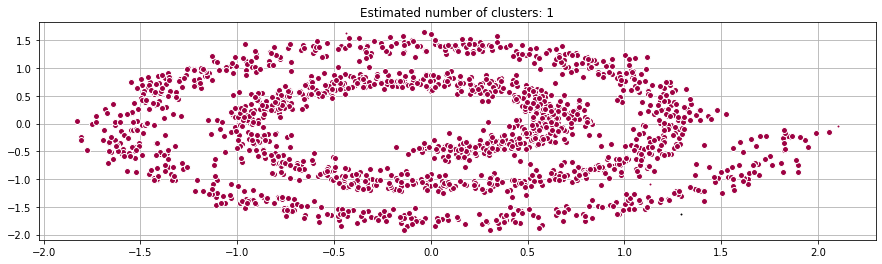

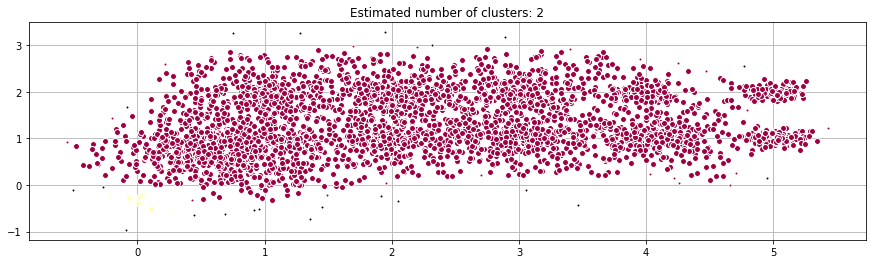

In [22]:
from sklearn.cluster import DBSCAN

#=====================================
# ENTER YOUR CODE HERE TO CHANGE MINPTS AND EPS FOR EACH DATASET
X2_minpts = X2_N # from above
X2_eps = 0.2
X3_minpts = X3_N # from above
X3_eps = 0.2
#=====================================

for i, (data, minpts, eps) in enumerate(zip([X2,X3],[X2_minpts,X3_minpts],[X2_eps,X3_eps])):

    db = DBSCAN(eps=eps, min_samples=minpts).fit(data)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # mark the samples that are considered "core"
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=(15,4))
    unique_labels = set(labels) # the unique labels
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        # plot the core points in this class
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.grid()
    plt.show()

___
Enter your answer here:

*Double Click to Edit*



___

________________________________________________________________________________________________________

That's all! Please **upload your rendered notebook** and please include **team member names** in the notebook submission.